In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pylab as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv('combined_data.csv', dtype={'fips': str}).set_index('fips')
with open('periods.pkl', 'rb') as handle:
    periods = pickle.load(handle)
periods_str = {key: f'{interval[0][:-3]}-{interval[1][:-3]}' for key, interval in periods.items()}
print(periods_str)

{'p1': '1/21-4/1', 'p2': '3/17-5/1', 'p3': '4/1-6/8', 'p4': '5/1-7/15', 'p5': '6/8-8/10', 'p6': '7/15-9/10', 'p7': '8/10-10/4', 'p8': '9/10-10/22'}


## Preprocess for regression

In [3]:
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_rural_pop',
    'income',
    'risk', 
    'risk_flu'
]
counts = [f'p{i + 1}' for i in range(8)] + ['covid']
pcs = [f'{c}_pc' for c in counts]

### Z-ify the covariates and `covidpc`. 
But don't z-ify `covid` because we are going to fit a Poisson

In [4]:
df_z = df[counts].copy()
for c in covariates + pcs:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
print(df_z.head())

       p1   p2   p3    p4    p5    p6    p7    p8  covid  population  ...  \
fips                                                                  ...   
01001   8   42  264   701   902   670   654   610   2023   -0.149053  ...   
01003  20  174  300  1324  3331  3179  2422  1797   6475    0.349320  ...   
01005   0   42  197   384   379   192   345   379    997   -0.241908  ...   
01007   3   42   76   196   363   328   244   245    811   -0.248733  ...   
01009   5   39   68   328   739   732   844   794   1893   -0.143225  ...   

       risk_flu     p1_pc     p2_pc     p3_pc     p4_pc     p5_pc     p6_pc  \
fips                                                                          
01001  0.816340 -0.124566 -0.225521  0.211921  1.076747  1.104153  0.410115   
01003  1.171755 -0.215131 -0.218349 -0.312708  0.089591  0.945651  0.695095   
01005 -0.009935 -0.368921  0.026553  0.716999  1.525563  1.001509 -0.123859   
01007  0.084901 -0.139945  0.073037  0.005390  0.510505  1.112577

## GLM Models

In [5]:
# for pc in pcs:
#     formula = f"{pc}~{'+'.join(covariates)}" 
#     # print(formula)
#     try:
#         model = smf.glm(
#             formula=formula,
#             data=df_z,
#             family=sm.families.Gaussian(sm.families.links.log())
#         ).fit()
#         print(f'{model.summary()}\n')
#     except:
#         print('esitmation fail\n')

In [6]:
dfs = []
for count in counts:
    formula = f"{count}~{'+'.join(covariates)}"  
    # print(formula)
    try:
        model = smf.glm(
            formula=formula,
            data=df_z,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        print(f'{model.summary()}\n')
        df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        df = df[['coef']].rename(columns={'coef': count})
        dfs.append(df)
    except:
        print('esitmation fail\n')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     p1   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3913e+05
Date:                Mon, 26 Oct 2020   Deviance:                   2.6966e+05
Time:                        13:59:54   Pearson chi2:                 4.80e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.8871      0.011     82.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     p6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 26 Oct 2020   Deviance:                   1.1262e+06
Time:                        13:59:55   Pearson chi2:                 1.33e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.7076      0.001   4738.

/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/yihuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


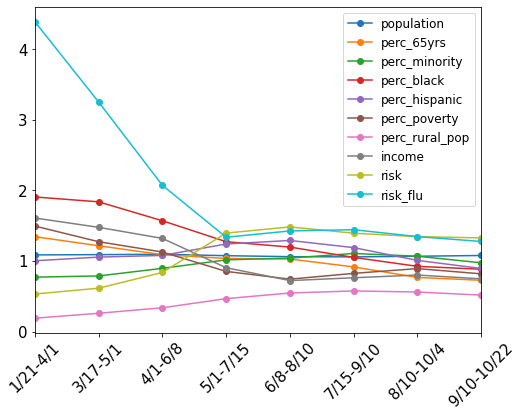

In [7]:
df_coef = pd.concat(dfs[:-1], axis=1).rename(columns=periods_str)
df_coef_exp = df_coef.apply(np.exp).T
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_coef_exp.drop(['Intercept'], axis=1).plot(ax=ax, marker='o')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.tick_params(axis='both', labelsize=15)
ax.legend(prop=dict(size=12))

In [8]:
dfs = []
covariates_ = [x for x in covariates if x != 'risk']
for count in counts:
    formula = f"{count}~{'+'.join(covariates_)}"  
    # print(formula)
    try:
        model = smf.glm(
            formula=formula,
            data=df_z,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        print(f'{model.summary()}\n')
        df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        df = df[['coef']].rename(columns={'coef': count})
        dfs.append(df)
    except:
        print('esitmation fail\n')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     p1   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5247e+05
Date:                Mon, 26 Oct 2020   Deviance:                   2.9634e+05
Time:                        13:59:56   Pearson chi2:                 5.25e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1146      0.010    108.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  covid   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2930e+06
Date:                Mon, 26 Oct 2020   Deviance:                   2.5606e+06
Time:                        13:59:56   Pearson chi2:                 2.93e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6795      0.001   8867.

/usr/local/lib64/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/yihuang/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


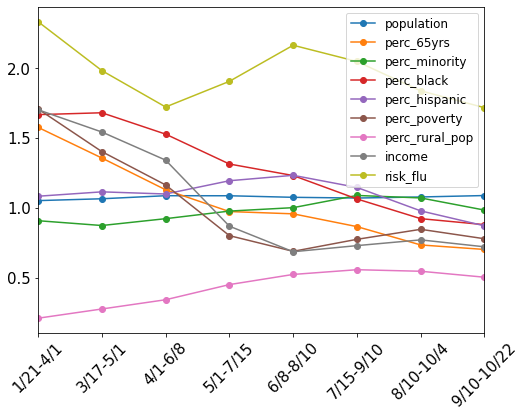

In [9]:
df_coef = pd.concat(dfs[:-1], axis=1).rename(columns=periods_str)
df_coef_exp = df_coef.apply(np.exp).T
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df_coef_exp.drop(['Intercept'], axis=1).plot(ax=ax, marker='o')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.tick_params(axis='both', labelsize=15)
ax.legend(prop=dict(size=12))

In [12]:
df_coef_exp.to_csv('../COVID_risk/Figures/diseases/Poisson_coef_exp.csv', float_format='%.6f')